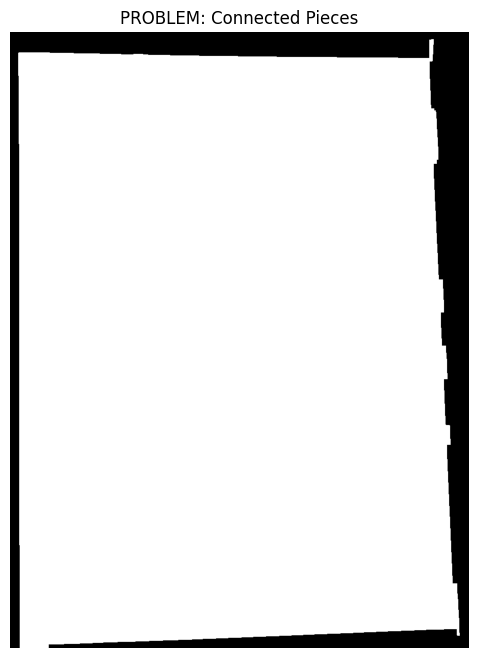

✅ Setup complete. You should see the problematic connected pieces above.


In [15]:
# STEP-BY-STEP PUZZLE PIECE SEPARATION
# Copy each cell one by one and run them to test different methods

# ========================================
# CELL 1: Setup and get to "Filled Regions"
# ========================================
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import os

# Simple peak detection function (replaces skimage dependency)
def find_local_maxima(image, min_distance=20, threshold=0.3):
    """Find local maxima in an image without skimage dependency"""
    from scipy.ndimage import maximum_filter

    # Apply maximum filter
    local_max = maximum_filter(image, size=min_distance) == image

    # Apply threshold
    above_threshold = image > threshold

    # Combine conditions
    peaks = local_max & above_threshold

    # Get coordinates
    coords = np.where(peaks)
    return list(zip(coords[0], coords[1]))

# Simple watershed function (replaces skimage dependency)
def simple_watershed(distance_map, markers, mask):
    """Simple watershed implementation using cv2"""
    # Convert markers to the format cv2 expects
    markers_cv2 = markers.astype(np.int32)

    # Create 3-channel image for cv2.watershed
    image_3ch = cv2.merge([distance_map, distance_map, distance_map])
    image_3ch = (image_3ch * 255).astype(np.uint8)

    # Apply watershed
    cv2.watershed(image_3ch, markers_cv2)

    # Apply mask
    result = markers_cv2.copy()
    result[mask == 0] = 0

    return result

def display_image(title, image, figsize=(10, 8)):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.axis('off')
    if len(image.shape) == 2 or image.shape[2] == 1:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

# Load your image
image_path = "images/pieces_black.jpg"  # Change this to your image
original_image = cv2.imread(image_path, cv2.IMREAD_COLOR)
gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

# Get to filled regions (the problematic result you showed)
blurred = cv2.GaussianBlur(gray_image, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)
edge_kernel = np.ones((3, 3), np.uint8)
thick_edges = cv2.dilate(edges, edge_kernel, iterations=2)
close_kernel = np.ones((5, 5), np.uint8)
closed_edges = cv2.morphologyEx(thick_edges, cv2.MORPH_CLOSE, close_kernel, iterations=3)

contours_temp, _ = cv2.findContours(closed_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
filled_image = np.zeros_like(gray_image)
cv2.drawContours(filled_image, contours_temp, -1, 255, thickness=cv2.FILLED)
display_image("PROBLEM: Connected Pieces", filled_image)

print("✅ Setup complete. You should see the problematic connected pieces above.")

🧪 TESTING METHOD 1: Watershed Separation


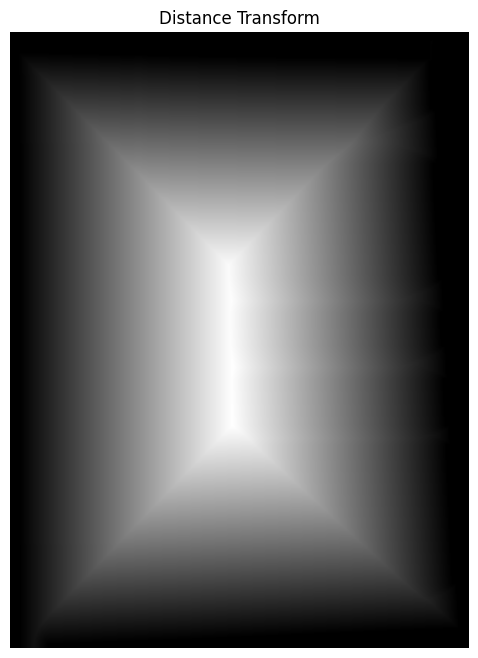

Found 180 piece centers


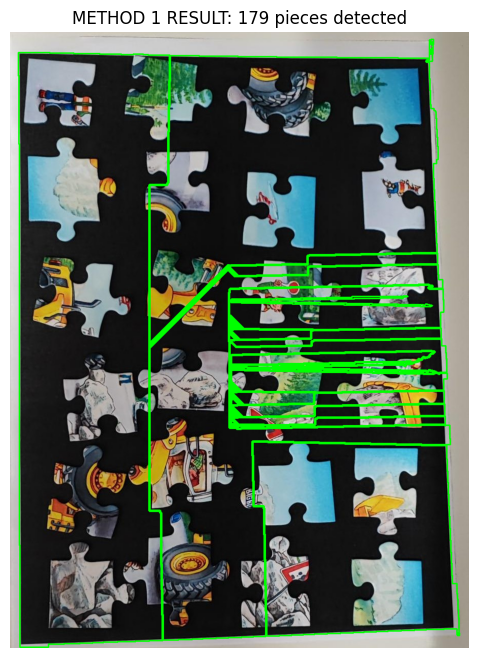

🎯 Method 1 found 179 pieces
👀 Look at the result above. Are pieces properly separated?


In [16]:
print("🧪 TESTING METHOD 1: Watershed Separation")

# Step 1: Distance transform
dist_transform = cv2.distanceTransform(filled_image, cv2.DIST_L2, 5)
display_image("Distance Transform", dist_transform)

# Step 2: Find piece centers
local_maxima = find_local_maxima(dist_transform, min_distance=20, threshold=0.3)
print(f"Found {len(local_maxima)} piece centers")

# Step 3: Create markers
markers = np.zeros_like(filled_image, dtype=np.int32)
for i, (y, x) in enumerate(local_maxima):
    markers[y, x] = i + 1

# Step 4: Watershed
watershed_result = simple_watershed(dist_transform, markers, filled_image)

# Step 5: Extract contours
watershed_contours = []
for label in range(1, len(local_maxima) + 1):
    piece_mask = (watershed_result == label).astype(np.uint8) * 255
    contours, _ = cv2.findContours(piece_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    watershed_contours.extend(contours)

# Show result
result1 = original_image.copy()
cv2.drawContours(result1, watershed_contours, -1, (0, 255, 0), 2)
display_image(f"METHOD 1 RESULT: {len(watershed_contours)} pieces detected", result1)

print(f"🎯 Method 1 found {len(watershed_contours)} pieces")
print("👀 Look at the result above. Are pieces properly separated?")

🧪 TESTING METHOD 2: Erosion-based Separation


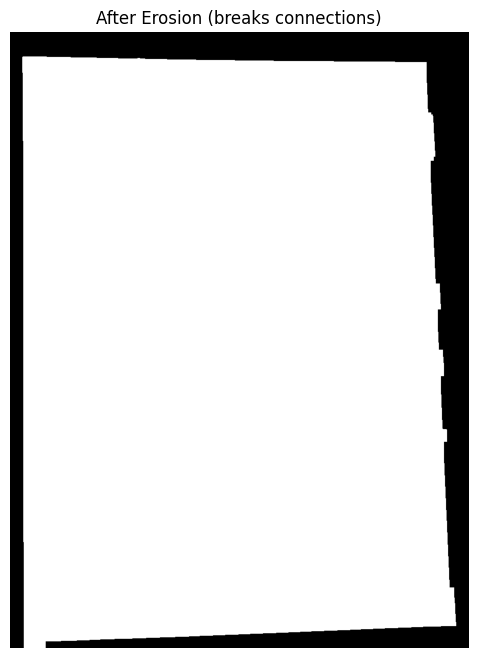

Found 1 components after erosion


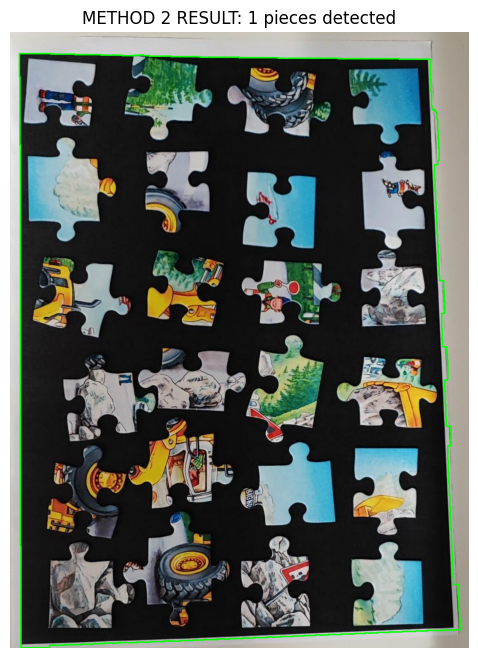

🎯 Method 2 found 1 pieces
👀 Look at the result above. Are pieces properly separated?


In [17]:
print("🧪 TESTING METHOD 2: Erosion-based Separation")

# Step 1: Erode to break connections
erosion_kernel = np.ones((8, 8), np.uint8)  # Try (6,6) or (10,10) if this doesn't work
eroded = cv2.erode(filled_image, erosion_kernel, iterations=2)
display_image("After Erosion (breaks connections)", eroded)

# Step 2: Find separate components
num_labels, labels = cv2.connectedComponents(eroded)
print(f"Found {num_labels-1} components after erosion")

# Step 3: Grow each component back
erosion_contours = []
for label in range(1, num_labels):
    # Get this component
    component_mask = (labels == label).astype(np.uint8) * 255

    # Grow it back
    dilated = cv2.dilate(component_mask, erosion_kernel, iterations=2)

    # Get contour
    contours, _ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    erosion_contours.extend(contours)

# Show result
result2 = original_image.copy()
cv2.drawContours(result2, erosion_contours, -1, (0, 255, 0), 2)
display_image(f"METHOD 2 RESULT: {len(erosion_contours)} pieces detected", result2)

print(f"🎯 Method 2 found {len(erosion_contours)} pieces")
print("👀 Look at the result above. Are pieces properly separated?")

🧪 TESTING METHOD 3: Just Better Filtering
Trying with different edge processing parameters...


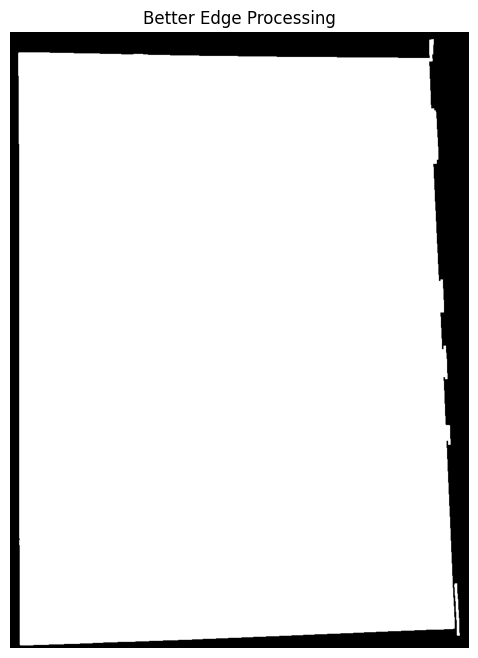

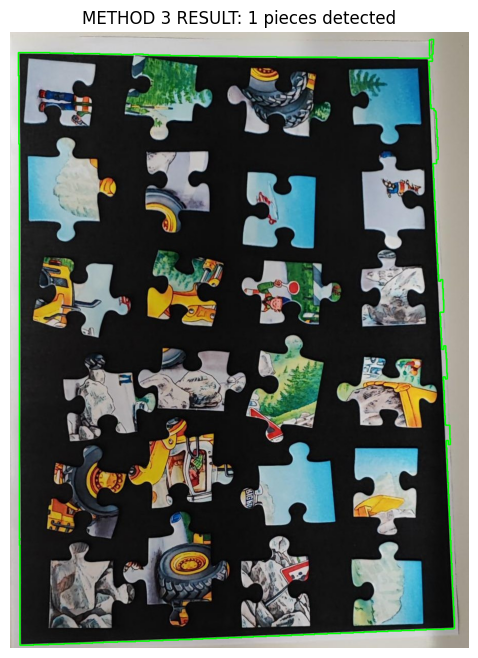

🎯 Method 3 found 1 pieces
👀 Look at the result above. Are pieces properly separated?


In [18]:
print("🧪 TESTING METHOD 3: Just Better Filtering")

# Sometimes the simplest approach works - just better edge processing
print("Trying with different edge processing parameters...")

# More aggressive edge closing
better_close_kernel = np.ones((3, 3), np.uint8)  # Smaller kernel
better_closed = cv2.morphologyEx(thick_edges, cv2.MORPH_CLOSE, better_close_kernel, iterations=1)

# Fill regions
better_contours_temp, _ = cv2.findContours(better_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
better_filled = np.zeros_like(gray_image)
cv2.drawContours(better_filled, better_contours_temp, -1, 255, thickness=cv2.FILLED)
display_image("Better Edge Processing", better_filled)

# Get final contours
better_contours, _ = cv2.findContours(better_filled, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Filter by area
better_contours = [cnt for cnt in better_contours if cv2.contourArea(cnt) > 500]

# Show result
result3 = original_image.copy()
cv2.drawContours(result3, better_contours, -1, (0, 255, 0), 2)
display_image(f"METHOD 3 RESULT: {len(better_contours)} pieces detected", result3)

print(f"🎯 Method 3 found {len(better_contours)} pieces")
print("👀 Look at the result above. Are pieces properly separated?")